In [17]:
import uproot
import numpy as np

file_prompt = uproot.open("Prompt_DstarToD0Pi.root")
tree_prompt = file_prompt["treeMLDstar"]

print(file_prompt.keys())
tree_prompt.keys()


['treeMLDstar;1']


['fCandidateSelFlag',
 'fChi2PCAD0',
 'fCosThetaStarD0',
 'fCpaD0',
 'fCpaXYD0',
 'fDecayLengthD0',
 'fDecayLengthNormalisedD0',
 'fDecayLengthXYD0',
 'fDecayLengthXYNormalisedD0',
 'fEta',
 'fEtaD0',
 'fFlagMcMatchRec',
 'fImpParamSoftPi',
 'fImpactParameter0',
 'fImpactParameter1',
 'fImpactParameterNormalised0',
 'fImpactParameterNormalised1',
 'fImpactParameterNormalisedSoftPi',
 'fImpactParameterProductD0',
 'fM',
 'fMD0',
 'fMaxNormalisedDeltaIPD0',
 'fNSigTofKa0',
 'fNSigTofKa1',
 'fNSigTofKaSoftPi',
 'fNSigTofPi0',
 'fNSigTofPi1',
 'fNSigTofPiSoftPi',
 'fNSigTpcKa0',
 'fNSigTpcKa1',
 'fNSigTpcKaSoftPi',
 'fNSigTpcPi0',
 'fNSigTpcPi1',
 'fNSigTpcPiSoftPi',
 'fNSigTpcTofKa0',
 'fNSigTpcTofKa1',
 'fNSigTpcTofKaSoftPi',
 'fNSigTpcTofPi0',
 'fNSigTpcTofPi1',
 'fNSigTpcTofPiSoftPi',
 'fPhi',
 'fPhiD0',
 'fPt',
 'fPtBhadMother',
 'fPtD0',
 'fPtProng0',
 'fPtProng1',
 'fPtSoftPi',
 'fY',
 'fYD0',
 'fInvDeltaMass']

In [18]:
import uproot
import numpy as np
import torch
import sklearn
import matplotlib.pyplot as plt

print("GPU available:", torch.cuda.is_available())


GPU available: True


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [20]:
file_prompt = uproot.open("Prompt_DstarToD0Pi.root")
file_nonprompt = uproot.open("Nonprompt_DstarToD0Pi.root")
file_bkg = uproot.open("Bkg_DstarToD0Pi.root")

tree_prompt = file_prompt["treeMLDstar"]
tree_nonprompt = file_nonprompt["treeMLDstar"]
tree_bkg = file_bkg["treeMLDstar"]

# -----------------------------
# Branches to load
# -----------------------------

branches_all = [
    "fPtD0",

    "fCpaD0",
    "fCpaXYD0",
    "fDecayLengthXYD0",
    "fImpactParameterProductD0",
    "fImpParamSoftPi",
    "fMaxNormalisedDeltaIPD0",

    "fNSigTpcPi0",
    "fNSigTpcKa0",
    "fNSigTofPi0",
    "fNSigTofKa0",

    "fNSigTpcPi1",
    "fNSigTpcKa1",
    "fNSigTofPi1",
    "fNSigTofKa1"
]


branches = [
   
    # Topological variables
    "fCpaD0",
    "fCpaXYD0",
    "fDecayLengthXYD0",
    "fImpactParameterProductD0",
    "fImpParamSoftPi",
    "fMaxNormalisedDeltaIPD0",

    # PID prong0
    "fNSigTpcPi0",
    "fNSigTpcKa0",
    "fNSigTofPi0",
    "fNSigTofKa0",

    # PID prong1
    "fNSigTpcPi1",
    "fNSigTpcKa1",
    "fNSigTofPi1",
    "fNSigTofKa1"
]

# -----------------------------
# Load arrays
# -----------------------------

arr_prompt = tree_prompt.arrays(branches_all, library="np")
arr_nonprompt = tree_nonprompt.arrays(branches_all, library="np")
arr_bkg = tree_bkg.arrays(branches_all, library="np")

pt_min = 6.0
pt_max = 8.0

mask_prompt = (arr_prompt["fPtD0"] > pt_min) & (arr_prompt["fPtD0"] < pt_max)
mask_nonprompt = (arr_nonprompt["fPtD0"] > pt_min) & (arr_nonprompt["fPtD0"] < pt_max)
mask_bkg = (arr_bkg["fPtD0"] > pt_min) & (arr_bkg["fPtD0"] < pt_max)

for b in branches:
    arr_prompt[b] = arr_prompt[b][mask_prompt]
    arr_nonprompt[b] = arr_nonprompt[b][mask_nonprompt]
    arr_bkg[b] = arr_bkg[b][mask_bkg]


# -----------------------------
# Build feature matrices
# -----------------------------

def build_X(arr):
    return np.column_stack([arr[b] for b in branches])

X_prompt = build_X(arr_prompt)
X_nonprompt = build_X(arr_nonprompt)
X_bkg = build_X(arr_bkg)

# -----------------------------
# Create labels
# -----------------------------

y_prompt = np.zeros(len(X_prompt))        # 0
y_nonprompt = np.ones(len(X_nonprompt))   # 1
y_bkg = 2 * np.ones(len(X_bkg))            # 2

# -----------------------------
# Merge datasets
# -----------------------------

X = np.vstack((X_prompt, X_nonprompt, X_bkg))
y = np.concatenate((y_prompt, y_nonprompt, y_bkg))

# -----------------------------
# Sanity checks
# -----------------------------

print("X shape:", X.shape)
print("y shape:", y.shape)
print("First 10 labels:", y[:10])

X shape: (727215, 14)
y shape: (727215,)
First 10 labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [21]:
X = np.nan_to_num(X, nan=0.0)


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Train-test split (70/30)
# -----------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    shuffle=True
)

# -----------------------------
# Feature normalization
# -----------------------------

scaler = StandardScaler()

# Fit ONLY on training data
X_train_scaled = scaler.fit_transform(X_train)

# Apply same transformation to test data
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# Sanity check
# -----------------------------

print("Mean of first feature (train):", X_train_scaled[:,0].mean())
print("Std of first feature (train):", X_train_scaled[:,0].std())


Mean of first feature (train): -6.2923584e-07
Std of first feature (train): 1.0


In [23]:
import torch
import torch.nn as nn

class D0Classifier(nn.Module):
    def __init__(self):
        super(D0Classifier, self).__init__()
        
        self.fc1 = nn.Linear(14, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 3)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)   # logits
        return x


In [24]:

# Create model
model = D0Classifier().to(device)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Optimizer (Adam)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001
)

# Learning-rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=20,   # reduce LR every 20 epochs
    gamma=0.5       # LR_new = LR_old * 0.5
)


In [25]:
print("NaNs in X:", np.isnan(X).sum())
print("Infs in X:", np.isinf(X).sum())


NaNs in X: 0
Infs in X: 0


Epoch 5/60, Loss = 0.3633
Epoch 10/60, Loss = 0.3252
Epoch 15/60, Loss = 0.3143
Epoch 20/60, Loss = 0.3091
Epoch 25/60, Loss = 0.3062
Epoch 30/60, Loss = 0.3041
Epoch 35/60, Loss = 0.3030
Epoch 40/60, Loss = 0.3017
Epoch 45/60, Loss = 0.3005
Epoch 50/60, Loss = 0.3001
Epoch 55/60, Loss = 0.2994
Epoch 60/60, Loss = 0.2987


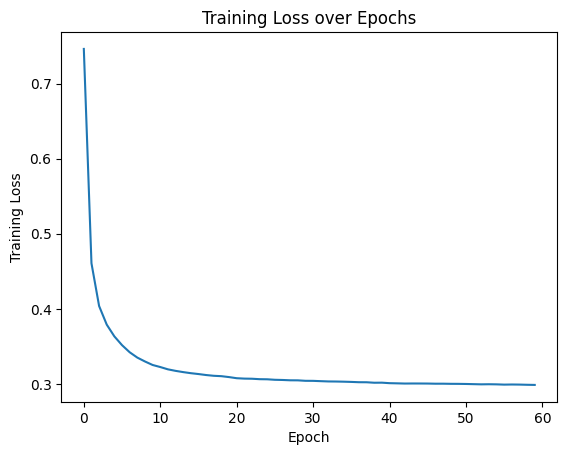

In [26]:

# Convert numpy arrays to torch tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

from torch.utils.data import TensorDataset, DataLoader

batch_size = 4096

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Number of epochs
n_epochs = 60

train_losses = []

# Training loop
for epoch in range(n_epochs):

    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss = {avg_loss:.4f}")

plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.show()

In [27]:
print(torch.version.cuda)
print(torch.cuda.is_available())

12.1
True


Test Accuracy: 0.8850503059610845
Confusion Matrix:
 [[ 19825   2839   6021]
 [  6078  26613   3054]
 [  4107   2979 146649]]


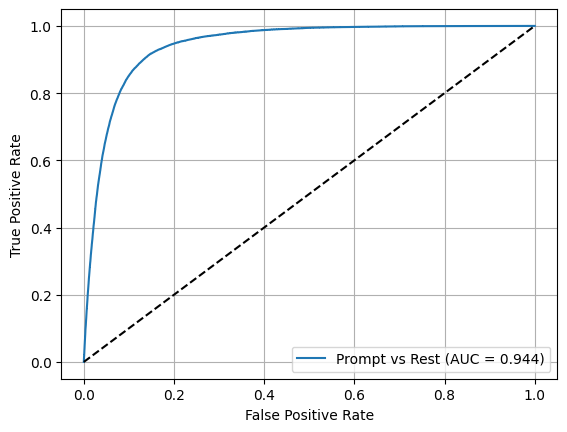

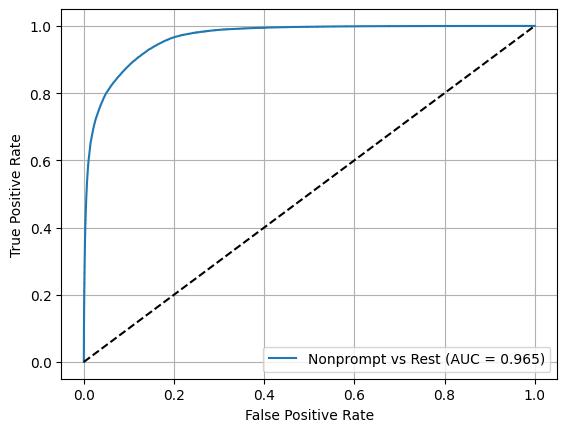

In [30]:

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc


# -----------------------------
# Set model to evaluation mode
# -----------------------------
model.eval()

with torch.no_grad():
    outputs_test = model(X_test_t)
    probs_test = torch.softmax(outputs_test, dim=1)
    preds_test = torch.argmax(probs_test, dim=1).cpu().numpy()

# -----------------------------
# Accuracy
# -----------------------------
acc = accuracy_score(y_test, preds_test)
print("Test Accuracy:", acc)

# -----------------------------
# Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, preds_test)
print("Confusion Matrix:\n", cm)

# -----------------------------
# ROC: Prompt vs Rest
# -----------------------------
y_true_prompt = (y_test == 0).astype(int)
scores_prompt = probs_test[:,0].cpu().numpy()

fpr_p, tpr_p, _ = roc_curve(y_true_prompt, scores_prompt)
auc_p = auc(fpr_p, tpr_p)

plt.figure()
plt.plot(fpr_p, tpr_p, label=f"Prompt vs Rest (AUC = {auc_p:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# -----------------------------
# ROC: Nonprompt vs Rest
# -----------------------------
y_true_np = (y_test == 1).astype(int)
scores_np = probs_test[:,1].cpu().numpy()

fpr_np, tpr_np, _ = roc_curve(y_true_np, scores_np)
auc_np = auc(fpr_np, tpr_np)

plt.figure()
plt.plot(fpr_np, tpr_np, label=f"Nonprompt vs Rest (AUC = {auc_np:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


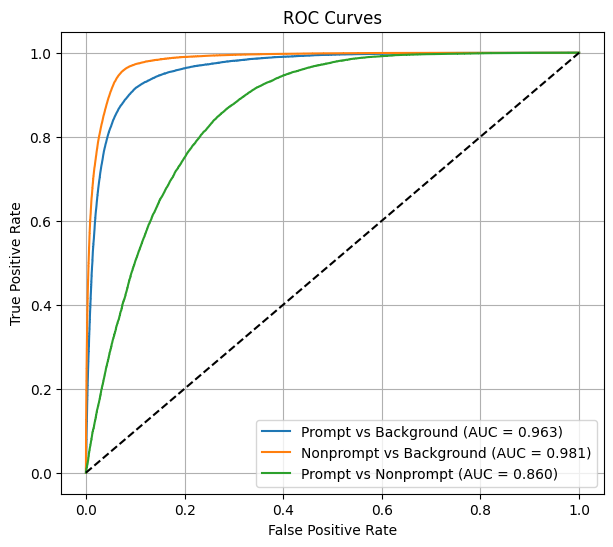

In [31]:
# Move probabilities to CPU numpy
probs_np = probs_test.cpu().numpy()

# --------------------------------
# Prompt vs Background
# --------------------------------
mask_pb = (y_test == 0) | (y_test == 2)
y_pb = (y_test[mask_pb] == 0).astype(int)   # prompt = 1, bkg = 0
scores_pb = probs_np[mask_pb, 0]             # P(prompt)

fpr_pb, tpr_pb, _ = roc_curve(y_pb, scores_pb)
auc_pb = auc(fpr_pb, tpr_pb)

# --------------------------------
# Nonprompt vs Background
# --------------------------------
mask_npb = (y_test == 1) | (y_test == 2)
y_npb = (y_test[mask_npb] == 1).astype(int)  # nonprompt = 1, bkg = 0
scores_npb = probs_np[mask_npb, 1]            # P(nonprompt)

fpr_npb, tpr_npb, _ = roc_curve(y_npb, scores_npb)
auc_npb = auc(fpr_npb, tpr_npb)

# --------------------------------
# Prompt vs Nonprompt
# --------------------------------
mask_pnp = (y_test == 0) | (y_test == 1)
y_pnp = (y_test[mask_pnp] == 0).astype(int)   # prompt = 1, nonprompt = 0
scores_pnp = probs_np[mask_pnp, 0]             # P(prompt)

fpr_pnp, tpr_pnp, _ = roc_curve(y_pnp, scores_pnp)
auc_pnp = auc(fpr_pnp, tpr_pnp)

# --------------------------------
# Plot all together
# --------------------------------
plt.figure(figsize=(7,6))

plt.plot(fpr_pb, tpr_pb, label=f"Prompt vs Background (AUC = {auc_pb:.3f})")
plt.plot(fpr_npb, tpr_npb, label=f"Nonprompt vs Background (AUC = {auc_npb:.3f})")
plt.plot(fpr_pnp, tpr_pnp, label=f"Prompt vs Nonprompt (AUC = {auc_pnp:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid()
plt.show()

In [32]:
torch.save(model.state_dict(), "D0_PID_NN.pth")
